# Importing Libraries

In [5]:
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, BatchNormalization, InputLayer
from tensorflow.keras.losses import Huber, MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Data Preparation

In [6]:
df = pd.read_csv('train.csv', sep=',')

df.head()


,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5


In [7]:
mean = df['current price'].mean()
std  = df['current price'].std()
print(mean)
print(std)
OW=1.1   # Weight of outliers, 5=(Inputting all of them)
lower_bound= mean - OW*std
upper_bound= mean + OW*std


308520.2425
126073.25914983758


In [8]:
filtered_df = df[(df['current price']>= lower_bound) & (df['current price']<=upper_bound)]

filtered_df.head()

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
5,6,650007,844846,6,148846,2,9,13,138,61,109,177933.5


In [9]:
data   = tf.constant(filtered_df, dtype=tf.float32)
data   = tf.random.shuffle(data)
x_data = data[:, 3:-1]
y_data = data[:, -1]
y_data = tf.expand_dims(y_data, axis = -1)
print(y_data.shape)
print(x_data.shape)

(666, 1)
(666, 8)


# Data Visualization

In [10]:
#sns.pairplot(df[['years','km','rating','condition','economy','top speed','hp','torque','current price']], diag_kind='kde')

**More homogenous dataset after supressing outliers weight**

In [11]:
#sns.pairplot(filtered_df[['years','km','rating','condition','economy','top speed','hp','torque','current price']], diag_kind='kde')

# Splitting Data

In [12]:
TrainRatio  = 0.8
ValRatio    = 0.1
TestRatio   = 0.1
DataSize    = len(y_data)
print(DataSize)

666


In [13]:
x_train = x_data[:int(DataSize*TrainRatio),:]
x_val   = x_data[int(DataSize*TrainRatio):int(DataSize*(TrainRatio+ValRatio)),:]
x_test  = x_data[int(DataSize*(TrainRatio+ValRatio)):int(DataSize*(TrainRatio+ValRatio+TestRatio)),:]
y_train = y_data[:int(DataSize*TrainRatio),:]
y_val   = y_data[int(DataSize*TrainRatio):int(DataSize*(TrainRatio+ValRatio)),:]
y_test  = y_data[int(DataSize*(TrainRatio+ValRatio)):int(DataSize*(TrainRatio+ValRatio+TestRatio)),:]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(532, 8)
(67, 8)
(67, 8)
(532, 1)
(67, 1)
(67, 1)


# Model Creation

In [14]:
normalizer = BatchNormalization()
model= tf.keras.Sequential([
    InputLayer(input_shape=(8,)),
    normalizer,
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 8)                 32        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               1152      
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5345 (20.88 KB)
Trainable params: 5329 (20.82 KB)
Non-trainable params: 16 (64.00 Byte)
_________________________________________________________________


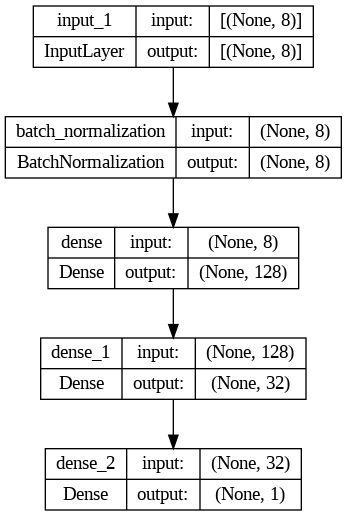

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
earlystopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=70)

In [17]:
TrainData = tf.data.Dataset.from_tensor_slices((x_train,y_train))
ValData   = tf.data.Dataset.from_tensor_slices((x_val, y_val))
TestData  = tf.data.Dataset.from_tensor_slices((x_test, y_test))

TrainData = TrainData.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
ValData   = ValData.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
TestData  = TestData.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
model.compile(optimizer=Adam(learning_rate=0.01), loss=MeanAbsoluteError())

In [18]:
history = model.fit(TrainData, validation_data=ValData, epochs=500, callbacks=earlystopping)

Epoch 1/500
17/17 [==============================] - 4s 14ms/step - loss: 307694.6562 - val_loss: 295140.1250
Epoch 2/500
17/17 [==============================] - 0s 4ms/step - loss: 307512.8438 - val_loss: 291892.1875
Epoch 3/500
17/17 [==============================] - 0s 5ms/step - loss: 306404.4375 - val_loss: 276509.9062
Epoch 4/500
17/17 [==============================] - 0s 4ms/step - loss: 301170.6250 - val_loss: 226229.7969
Epoch 5/500
17/17 [==============================] - 0s 4ms/step - loss: 282692.1562 - val_loss: 117409.8906
Epoch 6/500
17/17 [==============================] - 0s 5ms/step - loss: 232748.3906 - val_loss: 138033.4375
Epoch 7/500
17/17 [==============================] - 0s 4ms/step - loss: 149674.6875 - val_loss: 348584.3438
Epoch 8/500
17/17 [==============================] - 0s 4ms/step - loss: 113815.1797 - val_loss: 328824.6562
Epoch 9/500
17/17 [==============================] - 0s 4ms/step - loss: 101522.5938 - val_loss: 199287.8281
Epoch 10/500
17/17

In [19]:
model.evaluate(x_test,y_test)

3/3 [==============================] - 0s 4ms/step - loss: 26935.6875


26935.6875

# Plotting Results

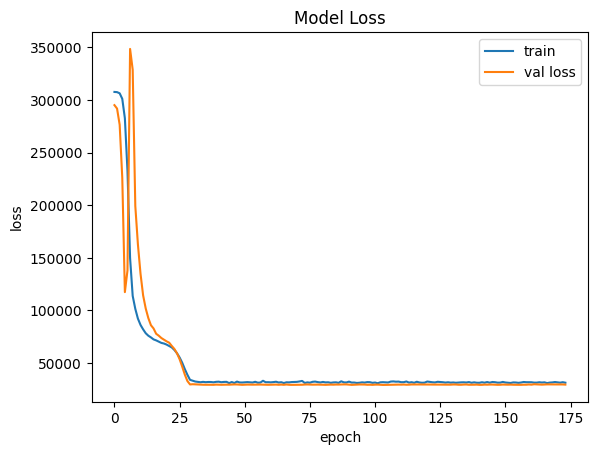

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val loss'])
plt.show()

In [21]:
y_pred=list(model.predict(x_test)[:,0])
y_true = list(y_test[:,0].numpy())


3/3 [==============================] - 0s 4ms/step


**Closest Prediction**

In [56]:
x=0
min=float('inf')
for i,(pred,true) in enumerate(zip(y_pred,y_true)):
  diff=abs(pred-true)
  if(diff)<min:
    min=diff
    x=i

print(y_true[x],y_pred[x],x)

388376.0 389228.34 8


In [23]:
shape=tf.shape(y_test)[0]
print(shape.numpy())

67


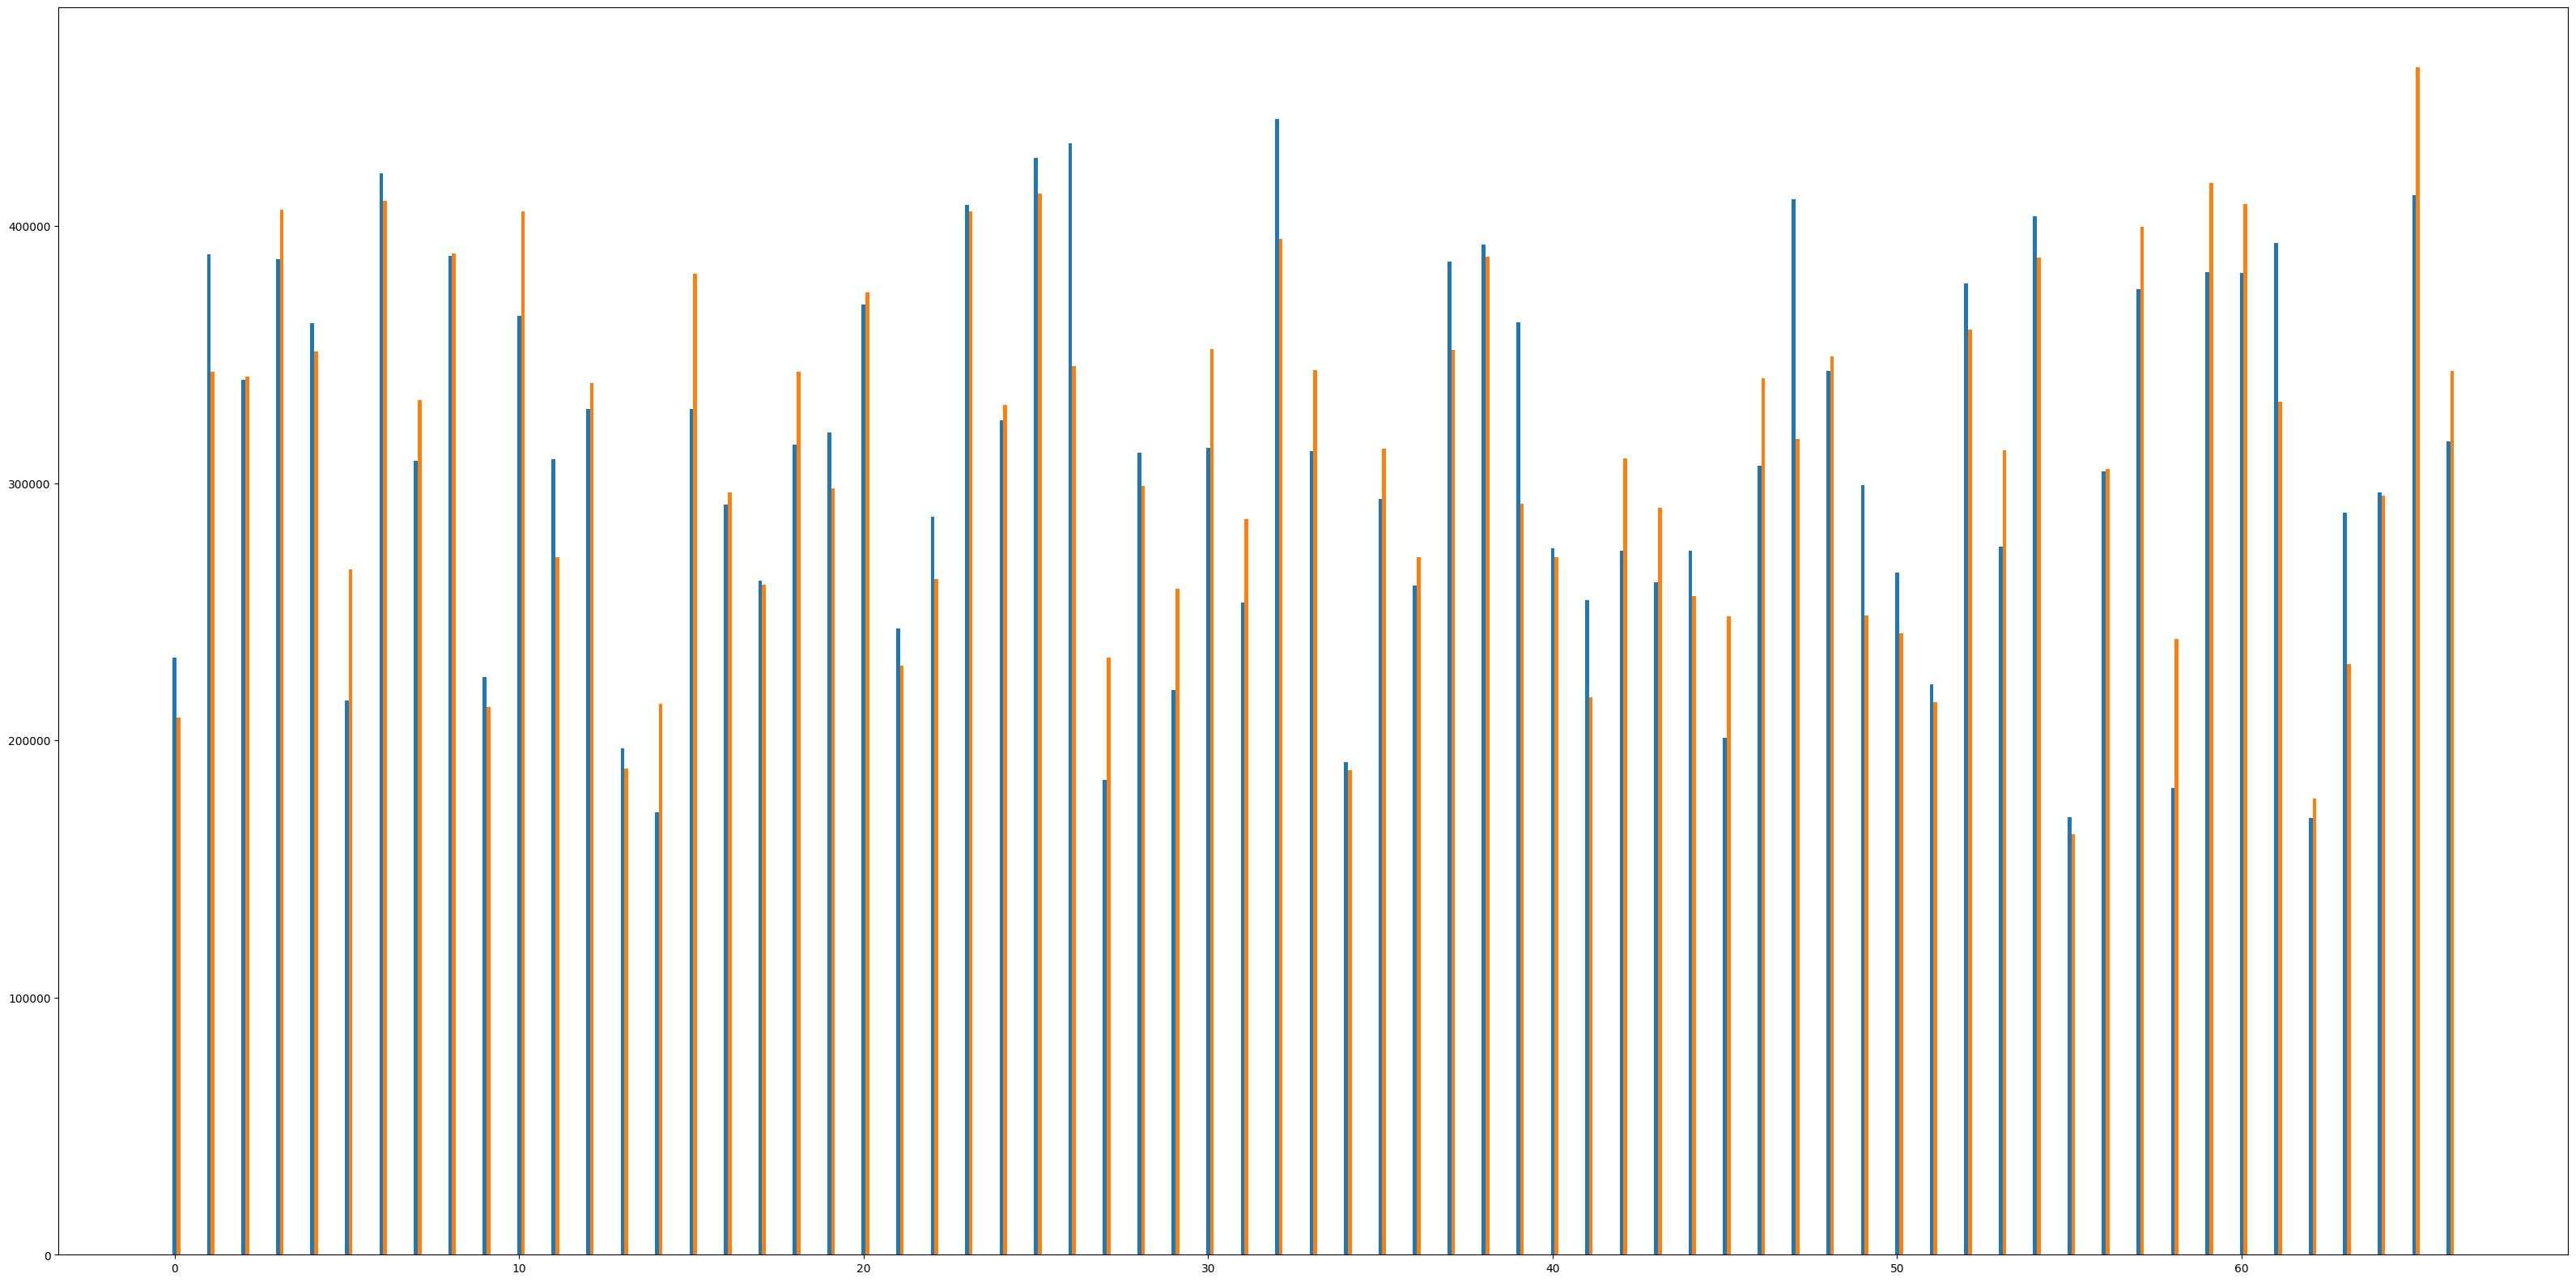

In [24]:

ind=np.arange(shape.numpy())
plt.figure(figsize=(40,20))
width=0.11
plt.bar(ind,y_true,width, label='true values')
plt.bar(ind+width,y_pred,width,label='predicted values')
plt.show()

# Sorting Layers by redundancy (least weights)

In [25]:
weights = []
Magnitudes = []
indexes = []
for layer in model.layers:
  if isinstance(layer, Dense):
    weights.append(layer.get_weights())

for weight in weights:
  Magnitudes.append(np.mean(np.abs(weight[0])))
  weights.pop()

for m in Magnitudes:
    least = np.argmin(Magnitudes)
    indexes.append(least)
    Magnitudes[least]=1000
print(indexes)

[1, 0]


In [26]:
#pip install nbconvert

In [27]:
#!apt-get install texlive-xetex


In [28]:
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/Untitled6.ipynb" --output-dir="/content/drive/MyDrive/Colab Notebooks/Output"


[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/Colab Notebooks/Untitled6.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--Jupy

In [29]:
!jt -t grade3

/bin/bash: line 1: jt: command not found
